In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import time
import datetime
import pandas
import numpy
import scipy.stats
import abcutils
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

## Global Analysis Constants

## Load and Synthesize Data from CSV

In [4]:
filtered_df = abcutils.sc18paper.load_dataset()

Loading from cache cache.hdf5
Start with 14536 rows before filtering
Dropped 42 rows after filter #0 (14494 left)
Dropped 14 rows after filter #1 (14480 left)
Dropped 38 rows after filter #2 (14442 left)
Dropped 5 rows after filter #3 (14437 left)
Dropped 2451 rows after filter #4 (11986 left)
11986 rows remaining


In [5]:
filtered_df.describe().T

,count,mean,std,min,25%,50%,75%,max
_jobid,11986.0,5.536253e+06,2.534192e+06,1.024637e+06,4.229402e+06,5.841630e+06,7.652503e+06,1.024653e+07
coverage_factor_bw,11084.0,8.812406e-01,2.025369e-01,1.731442e-02,8.646927e-01,9.716303e-01,9.970520e-01,1.193907e+00
coverage_factor_nodehrs,9463.0,5.633058e-02,6.668386e-01,1.590697e-02,1.976611e-02,2.112800e-02,2.236895e-02,1.397050e+01
coverage_factor_opens,11395.0,2.239087e+01,2.996970e+02,3.582019e-05,2.641649e-02,1.125151e-01,3.957630e-01,1.092300e+04
coverage_factor_ops,1779.0,1.433866e+02,2.399089e+03,2.020050e-04,4.422495e-02,3.276284e-01,6.907564e-01,6.553600e+04
coverage_factor_read_bw,11270.0,7.451235e+04,7.611786e+06,0.000000e+00,0.000000e+00,0.000000e+00,9.894372e-01,8.078577e+08
coverage_factor_read_ops,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coverage_factor_stats,9618.0,5.956903e-02,1.655919e-01,0.000000e+00,0.000000e+00,2.678525e-05,4.454824e-03,2.438095e+00
coverage_factor_write_bw,11318.0,1.284882e+06,3.465867e+07,0.000000e+00,0.000000e+00,4.073612e-01,9.933506e-01,1.450543e+09
coverage_factor_write_ops,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Basic Statistics

In [6]:
TEST_PLATFORMS = sorted(list(filtered_df['_test_platform'].unique()))
print "Test Platforms:\n  " + "\n  ".join(TEST_PLATFORMS)

BENCHMARK_IDS = sorted(list(filtered_df['_benchmark_id'].unique()))
print "\nBenchmarks:\n  " + "\n  ".join(BENCHMARK_IDS)

Test Platforms:
  cscratch@cori-knl
  mira-fs1@mira
  scratch1@edison
  scratch2@edison
  scratch3@edison

Benchmarks:
  dbscan_read_shared_read
  hacc_io_read_fpp_read
  hacc_io_write_fpp_write
  ior_fpp_read
  ior_fpp_write
  ior_shared_read
  ior_shared_write
  vpicio_uni_shared_write


In [7]:
total_days = (abcutils.sc18paper.DATE_END - abcutils.sc18paper.DATE_START).total_seconds() / 86400
print "Total days: %.1f" % total_days

total_logs = filtered_df['darshan_agg_perf_by_slowest_posix'].count()
print "Total darshan logs: %d" % total_logs

expected_logs = (total_days * len(TEST_PLATFORMS) * len(BENCHMARK_IDS))
percent_found = 100.0 * total_logs / expected_logs
print "Percent benchmarks run: %.1f%%" % (percent_found)
print "Percent benchmarks missing: %.1f%%" % (100 - percent_found)

grouped_df = filtered_df.groupby(['_test_platform', '_benchmark_id'])
grouped_df['darshan_agg_perf_by_slowest_posix'].describe()['count'] / total_days

Total days: 366.0
Total darshan logs: 11986
Percent benchmarks run: 81.9%
Percent benchmarks missing: 18.1%


_test_platform     _benchmark_id          
cscratch@cori-knl  dbscan_read_shared_read    0.857923
                   hacc_io_read_fpp_read      0.860656
                   hacc_io_write_fpp_write    0.860656
                   ior_fpp_read               0.857923
                   ior_fpp_write              0.868852
                   ior_shared_read            0.849727
                   ior_shared_write           0.874317
                   vpicio_uni_shared_write    0.860656
mira-fs1@mira      dbscan_read_shared_read    0.726776
                   hacc_io_read_fpp_read      0.751366
                   hacc_io_write_fpp_write    0.784153
                   ior_fpp_read               0.756831
                   ior_fpp_write              0.800546
                   ior_shared_read            0.762295
                   ior_shared_write           0.803279
                   vpicio_uni_shared_write    0.748634
scratch1@edison    dbscan_read_shared_read    0.688525
                   hac

In [8]:
grouped_df['_datetime_start'].describe()

count unique                  top  \
_test_platform    _benchmark_id                                               
cscratch@cori-knl dbscan_read_shared_read   314    314  2017-07-23 20:35:46   
                  hacc_io_read_fpp_read     315    315  2017-12-20 10:03:33   
                  hacc_io_write_fpp_write   315    315  2017-09-14 19:08:50   
                  ior_fpp_read              314    314  2017-03-15 19:12:26   
                  ior_fpp_write             318    318  2017-12-09 18:39:22   
                  ior_shared_read           311    311  2017-11-15 19:09:17   
                  ior_shared_write          320    320  2017-07-26 19:27:09   
                  vpicio_uni_shared_write   315    315  2018-01-02 20:02:56   
mira-fs1@mira     dbscan_read_shared_read   266    266  2017-09-21 13:37:53   
                  hacc_io_read_fpp_read     275    275  2017-10-13 23:10:13   
                  hacc_io_write_fpp_write   287    287  2017-07-28 21:52:02   
                  ior_fpp_read              277    277  2017-03-10 02:22:38   
                  ior_fpp_write             293    293  2017-10-28 07:41:04   
                  ior_shared_read           279    279  2017-11-08 07:33:59   
                  ior_shared_write          294    294  2017-11-08 02:40:51   
                  vpicio_uni_shared_write   274    274  2018-02-13 20:22:23   
scratch1@edison   dbscan_read_shared_read   252    252  2017-05-27 20:19:04   
                  hacc_io_read_fpp_read     280    280  2018-01-03 18:24:32   
                  hacc_io_write_fpp_write   280    280  2018-01-03 18:23:25   
                  ior_fpp_read              281    281  2017-03-09 17:49:46   
                  ior_fpp_write             287    287  2017-11-05 18:28:47   
                  ior_shared_read           281    281  2017-04-17 18:51:31   
                  ior_shared_write          301    301  2017-04-27 19:31:39   
                  vpicio_uni_shared_write   268    268  2017-09-03 19:24:04   
scratch2@edison   dbscan_read_shared_read   282    282  2017-05-24 18:55:56   
                  hacc_io_read_fpp_read     314    314  2017-05-11 19:05:27   
                  hacc_io_write_fpp_write   314    314  2017-03-29 19:10:10   
                  ior_fpp_read              316    316  2017-03-17 18:51:15   
                  ior_fpp_write             322    322  2017-09-14 20:22:12   
                  ior_shared_read           318    318  2017-07-02 18:49:28   
                  ior_shared_write          323    323  2017-05-08 19:24:35   
                  vpicio_uni_shared_write   297    297  2017-02-19 10:01:19   
scratch3@edison   dbscan_read_shared_read   283    283  2017-03-26 19:05:15   
                  hacc_io_read_fpp_read     317    317  2017-12-14 18:22:48   
                  hacc_io_write_fpp_write   317    317  2018-01-14 19:30:37   
                  ior_fpp_read              321    321  2017-02-14 01:44:58   
                  ior_fpp_write             322    322  2017-09-06 19:20:43   
                  ior_shared_read           321    321  2017-11-13 18:17:15   
                  ior_shared_write          323    323  2017-02-19 10:01:23   
                  vpicio_uni_shared_write   299    299  2017-09-18 20:45:34   

                                          freq                first  \
_test_platform    _benchmark_id                                       
cscratch@cori-knl dbscan_read_shared_read    1  2017-02-14 02:38:23   
                  hacc_io_read_fpp_read      1  2017-02-14 02:30:07   
                  hacc_io_write_fpp_write    1  2017-02-14 02:27:25   
                  ior_fpp_read               1  2017-02-14 02:25:57   
                  ior_fpp_write              1  2017-02-14 02:23:51   
                  ior_shared_read            1  2017-02-15 11:07:18   
                  ior_shared_write           1  2017-02-14 02:22:40   
                  vpicio_uni_shared_write    1  2017-02-14 02:32:36   
mira-fs1@mira

## Boxplots

In [9]:
TEST_PLATFORMS = [
    'scratch1@edison',
#   'scratch2@edison',
    'scratch3@edison',
    'cscratch@cori-knl',
    'mira-fs1@mira'
]

In [10]:
boxplot_settings = {
    'fontsize': 16,
    'darshan_normalized_perf_by_max': {
        'output_file': "perf-boxplots.pdf",
        'ylabel': "Fraction Peak Performance",
        'title_pos': [ 
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 16},
            {'x': 0.04, 'y': 0.02, 'horizontalalignment': 'left', 'fontsize': 16}]
    },
}

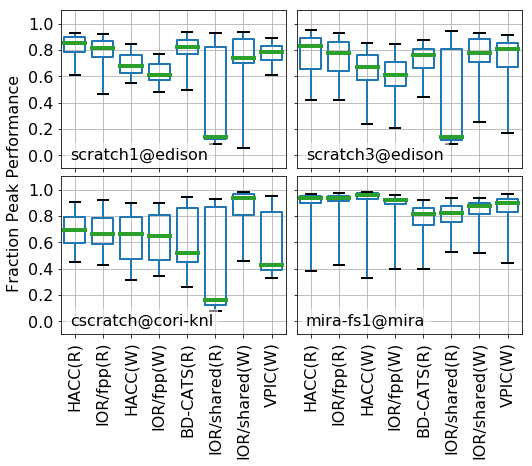

In [11]:
NUM_ROWS = 2
NUM_COLS = len(TEST_PLATFORMS) / 2

assert NUM_ROWS * NUM_COLS == len(TEST_PLATFORMS)

grouped_df = filtered_df.groupby('_test_platform')

fig, axes = matplotlib.pyplot.subplots(nrows=NUM_ROWS,
                                       ncols=NUM_COLS,
                                       # sharex causes problems if not all axes contain data
                                       #sharex=True,
                                       sharey=True)
fig.set_size_inches(4*NUM_COLS,3*NUM_ROWS)

### Draw subplots that contain data
for index, fs in enumerate(TEST_PLATFORMS):
    irow = index / NUM_COLS
    icol = index % NUM_COLS
    ax = axes[irow, icol]
    abcutils.plot.grouped_boxplot(grouped_df.get_group(fs),
                                  'darshan_normalized_perf_by_max',
                                  ax=ax,
                                  fontsize=16)
    title = ax.set_title(fs, **(boxplot_settings['darshan_normalized_perf_by_max']['title_pos'][irow]))
    title.set_bbox({'color': 'white', 'alpha': 0.5})
#   ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

### Set global figure labels 
fig.suptitle("")
fig.text(0.02, 0.5,
         boxplot_settings['darshan_normalized_perf_by_max']['ylabel'],
         verticalalignment='center',
         horizontalalignment='center',
         rotation='vertical',
         fontsize=boxplot_settings['fontsize'])
fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.savefig('figs/summary_boxplots.pdf', bbox_inches='tight')

## Histogram of Coverage Factor

In [12]:
histogram_settings = {
    'fontsize': 20,
    'darshan_normalized_perf_by_max': {
        'output_file': "perf-boxplots.pdf",
        'ylabel': "Fraction of\nPeak Performance",
        'title_pos': [ 
            {'x': 0.04, 'y': 0.90, 'horizontalalignment': 'left', 'fontsize': 14},
            {'x': 0.04, 'y': 0.90, 'horizontalalignment': 'left', 'fontsize': 14}]
    },
}

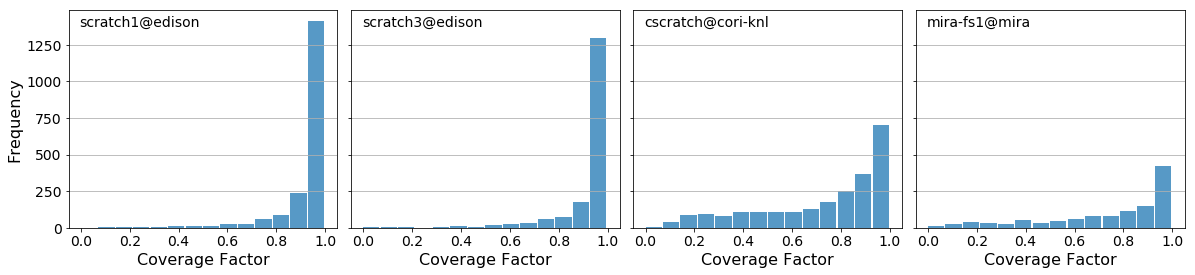

In [13]:
NUM_ROWS = 1
NUM_COLS = len(TEST_PLATFORMS)

grouped_df = filtered_df.groupby('_test_platform')

fig, axes = matplotlib.pyplot.subplots(nrows=NUM_ROWS,
                                       ncols=NUM_COLS,
                                       # sharex causes problems if not all axes contain data
                                       #sharex=True,
                                       sharey=True)
fig.set_size_inches(20,4)

### Draw subplots that contain data
for index, fs in enumerate(TEST_PLATFORMS):
    irow = index / NUM_COLS
    ax = axes[index]
    
    grouped_df.get_group(fs)

    y1 = grouped_df.get_group(fs)['coverage_factor_bw'].dropna()
    y2 = grouped_df.get_group(fs)['coverage_factor_nodehrs'].dropna()
    common_opts = {
        "width": 1.0/15.0,
        "bins": numpy.linspace(0.0, 1.0, 15),
        "alpha": 0.75,
        "linewidth": 3.0,
    #   "zorder": 9,
    }

    for y, label in [(y1, 'Coverage Factor (BW)')]: #, (y2, 'Coverage Factor (NodeHrs)')]:
        ax.hist(y, label=label, **common_opts)

    ax.set_title(fs, fontsize=20)
    ax.set_xlabel("Coverage Factor", fontsize=16)
    ax.set_ylabel("Frequency", fontsize=16)
#   ax.legend(fontsize=12)
    ax.yaxis.grid()
#   ax.set_yscale("log")
#   ax.set_ylim([1, 1e4])
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.label_outer()

    title = ax.set_title(fs, **(histogram_settings['darshan_normalized_perf_by_max']['title_pos'][irow]))
    title.set_bbox({'color': 'white', 'alpha': 0.5})

### Set global figure labels 
fig.suptitle("")
fig.subplots_adjust(hspace=0.05, wspace=0.05)

## Performance Evolution Over Time

In [14]:
print "Valid benchmark_id values:\n"
print "\n".join(filtered_df['_benchmark_id'].unique())

Valid benchmark_id values:

dbscan_read_shared_read
hacc_io_read_fpp_read
hacc_io_write_fpp_write
ior_shared_write
ior_fpp_write
ior_shared_read
ior_fpp_read
vpicio_uni_shared_write


In [15]:
def draw_boxplot_timeseries(df, date_start, date_end, benchmark_id, plot_metric):
    NUM_ROWS = len(TEST_PLATFORMS)
    NUM_COLS = 1
    date_delta = datetime.timedelta(days=7)
    fig, axes = matplotlib.pyplot.subplots(nrows=NUM_ROWS,
                                           ncols=NUM_COLS,
                                           sharex=True)
    fig.set_size_inches(16, 2.5*NUM_ROWS)
    
    xlabel = "Week in 2017"
    ylabel = "%s\n(%s)" % (abcutils.CONFIG['benchmark_labels'].get(benchmark_id, benchmark_id),
                           abcutils.CONFIG['metric_labels'].get(plot_metric, plot_metric))

    for index, test_platform in enumerate(TEST_PLATFORMS):
        df_filter = ((df['_test_platform'] == test_platform) &
                    (df['_benchmark_id'] == benchmark_id))

        ax = axes[index]
        ax.set_ylabel(ylabel)

        abcutils.plot.timeseries_boxplot(df[df_filter], plot_metric, date_start, date_end, date_delta, ax=ax)

        title = ax.set_title(test_platform, **({'x': 0.01, 'y': 0.04, 'horizontalalignment': 'left', 'fontsize': 14}))
        title.set_bbox({'color': 'white', 'alpha': 0.5})

    ### Set global figure labels 
    axes[-1].set_xlabel(xlabel)
    fig.suptitle("")
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
#   output_file = "%s.png" % benchmark_id
#   fig.savefig(output_file, bbox_inches="tight")
#   print "Saved to %s" % output_file

In [16]:
#plot_metric = 'darshan_normalized_perf_by_max'
# plot_metric = 'darshan_agg_perf_by_slowest_posix_gibs'

for benchmark_id in BENCHMARK_IDS:
    draw_boxplot_timeseries(filtered_df, abcutils.sc18paper.DATE_START, abcutils.sc18paper.DATE_END, benchmark_id, plot_metric)